In [7]:
import pandas as pd
from typing import Literal
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from utils.loader import MovieLensDataset
from arquitecture.Recommender import Recommender, Recommender_2
from arquitecture.components.PatterAnalyzer import PatternAnalyzer
import torch.optim as optim
import matplotlib.pyplot as plt
SEED = 55
BATCH = 2000
NUN_THREADS = 6
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCH = 150
LEARNING_RATE = 0.001


In [2]:
train_dataset = MovieLensDataset(ml_path="ml-100k", split="train", transpose_ratings=False, seed=SEED)
test_dataset = MovieLensDataset(ml_path="ml-100k", split="test", transpose_ratings=False, seed=SEED)
val_dataset = MovieLensDataset(ml_path="ml-100k", split="val", transpose_ratings=False, seed=SEED)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=NUN_THREADS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=True, num_workers=NUN_THREADS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH, shuffle=True, num_workers=NUN_THREADS)

In [3]:
user_data_tensor, rating_train_tensor, rating_test_tensor = val_dataset.__getitem__(1)

print("User Data Tensor Size:", user_data_tensor.size())
print("Rating Train Tensor Size:", rating_train_tensor.size())
print("Rating Test Tensor Size:", rating_test_tensor.size())

User Data Tensor Size: torch.Size([23])
Rating Train Tensor Size: torch.Size([19, 22])
Rating Test Tensor Size: torch.Size([19])


In [4]:
height=19
width=22
user_input_size = 23
    # Crear instancia del modelo
pattern_analyzer = PatternAnalyzer(conv_structure=[1,8,8,16,16,32,32],
                            input_size=torch.Size((height, width)),
                            pool_depth=3,
                            expert_hidden_size=12,
                            expert_output_len=8,
                            final_mlp_factor=2,
                            final_mlp_output_len=12,
                            ).to(DEVICE)
    
model = Recommender(
        user_data_input_size=user_input_size,
        user_data_analizer_factor = 1,
        user_data_analizer_output_size = 10,
        pattern_analyzer=pattern_analyzer,
        final_regressor_factor=1,
        final_regressor_output_len=19
    ).to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

Model parameters: 513534


In [5]:
# Crear el optimizador, por ejemplo, usando Adam con una tasa de aprendizaje de 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Crear la función de pérdida para regresión (Mean Squared Error Loss)
criterion = nn.MSELoss(reduction="sum")

In [6]:
train_loss_record = []
valid_loss_record = []
for epoch in range(NUM_EPOCH):
    # --- Training Phase ---
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    
    for user_data_tensor, rating_train_tensor, rating_test_tensor in train_dataloader:
        optimizer.zero_grad()

        outputs = model(user_data_tensor.float().to(DEVICE), rating_train_tensor.float().to(DEVICE)).to(DEVICE)        
        loss = criterion(outputs.to(DEVICE), rating_test_tensor.float().to(DEVICE)) 
        
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update model parameters
        running_train_loss += loss.item() * rating_test_tensor.size()[1]
    
    epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
    train_loss_record.append(epoch_train_loss)
    # --- Validation Phase ---32
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for user_data_tensor, rating_train_tensor, rating_test_tensor in val_dataloader:
            
            outputs = model(user_data_tensor.float().to(DEVICE), rating_train_tensor.float().to(DEVICE))        
            loss = criterion(outputs, rating_test_tensor.float().to(DEVICE)) 
            
            running_val_loss += loss.item() * rating_test_tensor.size()[1]
    
    epoch_val_loss = running_val_loss / len(val_dataloader.dataset)
    valid_loss_record.append(epoch_val_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCH}] - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

Epoch [1/150] - Train Loss: 38.6441, Val Loss: 39.0035
Epoch [2/150] - Train Loss: 38.2989, Val Loss: 38.6461
Epoch [3/150] - Train Loss: 37.9568, Val Loss: 38.2878
Epoch [4/150] - Train Loss: 37.6146, Val Loss: 37.9296
Epoch [5/150] - Train Loss: 37.2733, Val Loss: 37.5655
Epoch [6/150] - Train Loss: 36.9266, Val Loss: 37.1973
Epoch [7/150] - Train Loss: 36.5758, Val Loss: 36.8111
Epoch [8/150] - Train Loss: 36.2084, Val Loss: 36.3941
Epoch [9/150] - Train Loss: 35.8118, Val Loss: 35.9656
Epoch [10/150] - Train Loss: 35.4019, Val Loss: 35.4746
Epoch [11/150] - Train Loss: 34.9332, Val Loss: 34.9594
Epoch [12/150] - Train Loss: 34.4388, Val Loss: 34.2637
Epoch [13/150] - Train Loss: 33.7696, Val Loss: 33.3340
Epoch [14/150] - Train Loss: 32.8847, Val Loss: 32.0264
Epoch [15/150] - Train Loss: 31.6464, Val Loss: 30.5996
Epoch [16/150] - Train Loss: 30.3761, Val Loss: 31.2726
Epoch [17/150] - Train Loss: 31.2188, Val Loss: 30.2988
Epoch [18/150] - Train Loss: 30.2997, Val Loss: 29.4139
E

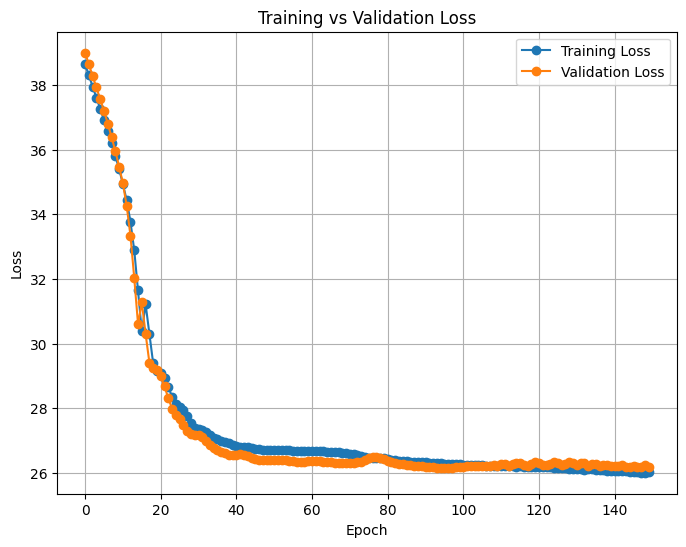

In [ ]:
# Create a plot with specified figure size
plt.figure(figsize=(8, 6))

# Plot training and validation loss records
plt.plot(train_loss_record, label="Training Loss", marker='o')
plt.plot(valid_loss_record, label="Validation Loss", marker='o')

# Adding labels and title for clarity
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

# Add a legend to differentiate the plots
plt.legend()

# Optionally add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()